<a id="top"></a>
# Long Period TESS Targets with Kepler Counterparts
***


## Prerequisites
- Python syntax
- astropy tables
- for loops
- Something about exoplanet transits, link to free resource

## Learning Goals

By the end of this tutorial, you will:

- 

To use as a guideline:
"Set a minimum threshold for orbital period (should be long-period orbits, greater than 6mos). Find all TESS 20-seconds targets that have data for these Kepler TCEs to create an even longer baseline."

## Introduction
The [Kepler initial and follow-on (K2) missions confirmed over 2,600 exoplanets](https://exoplanets.nasa.gov/keplerscience/) and contributed to an unprecedented exposion of knowledge about planetary systems in our galaxy. In addition to confirmed exoplanets, Kepler identified thousands more potential planetary candidates, referred to as Kepler Objects on Interest (KOI's). 

The Transiting Exoplanet Survey Satellite (TESS) began its observations just before the completion of the K2 mission; there may be long-period (greater than 6 months) exoplanets whose transits were observed by both missions. By combining observations from both missions, we could potentially view multiple transits and confirm the existence of new exoplanets. 

Possible transits observed by Kepler are called Threshold Crossing Events, or TCEs. More specifically, according to the [NASA Exoplanet Archive documentation](https://exoplanetarchive.ipac.caltech.edu/docs/Kepler_TCE_docs.html), 

>"A Threshold-Crossing Event (TCE) is a sequence of transit-like features in the flux time series of a given target that resembles the signature of a transiting planet to a sufficient degree that the target is passed on for further analysis."

NOT UPDATED: The workflow for this notebook consists of:
* [Main Content](#Main-Content)
    * [Loading Data](#Loading-Data)
    * [File and Data Information](#File-and-Data-Information)
* [Visualization](#Visualization)
* [Exercises](#Exercises)
* [Additional Resources](#Additional-Resources)

## Imports
Describe the main packages we're using here and their use-case for this notebook. If there's something unusual, explain what the library is, and why we need it.
- *numpy* to handle array functions
- *astropy.io fits* for accessing FITS files
- *astropy.table Table* for creating tidy tables of the data
- *matplotlib.pyplot* for plotting data

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from astropy.io import fits
from astropy.table import Table
from astroquery.mast import Mast
from astroquery.mast import Observations


# Added by JRK
import requests
from astropy.io import ascii
import lightkurve as lk
import astropy.units as u # May not end up using?
from astroquery.simbad import Simbad
from astroquery.vizier import Vizier

***

## Load full table of Kepler Threshold Crossing Events, or TCEs and filter by period

The NASA Exoplanet Archive hosts many useful data tables, including the list of [Threshold Crossing Events (TCEs)](https://exoplanetarchive.ipac.caltech.edu/docs/program_interfaces.html#tce). We'll use the Quarter 1 through Quarter 17 Data Release 24 (DR24) version. These TCEs were evaluated by an autovetter, a machine-learning program that classified TCEs into three categories: PC (Planet Candidate), AFP (Astrophysical False Positive), and NTP (Non-Transiting Phenomenon). More information about the autovetter can be found in [McCauliff et al. 2015 ApJ 806, 6](https://ui.adsabs.harvard.edu/abs/2015ApJ...806....6M/abstract).

We can point the astropy Table reader to a URL that contains the data table.

In [2]:
# Load the TCE DR24 table as an astropy table and view a preview.
# The online version doesn't have all the columns that you can download from the interactive table, in particular, the autovetter ones.
#tab=Table.read('https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=q1_q17_dr24_tce',format='ascii.csv')
tab=Table.read('./q1_q17_dr24_tce_2023.05.29_11.07.52.csv',format='ascii.csv',comment='#') 
tab.pprint()

rowid  kepid   tce_plnt_num ... tce_dikco_msky tce_dikco_msky_err
----- -------- ------------ ... -------------- ------------------
    1  1162345            2 ...        0.46282                1.1
    2  1292087            2 ...        0.22049               0.22
    3  1293031            2 ...        0.41872              0.207
    4  1162345            3 ...        0.13742              0.196
    5  1164109            1 ...         15.207             0.0893
    6   757450            1 ...        0.12498             0.0763
    7   892667            1 ...        0.18106              0.124
    8   892772            1 ...         5.2002              0.165
    9  1026032            1 ...       0.064587              0.077
   10  1026032            2 ...        0.13865              0.084
  ...      ...          ... ...            ...                ...
20357 11809346            1 ...       0.090355             0.0786
20358 11826440            2 ...        0.58446              0.755
20359 1185

As we can see, the table has over 20,000 rows, so we will want to narrow down by targets most of interest for us. However, the "pretty print" preview of the table does not show us all of the columns. Let's see the names of all of the columns, and only retain those we will need.

In [3]:
print(tab.columns)

<TableColumns names=('rowid','kepid','tce_plnt_num','tce_rogue_flag','tce_delivname','rowupdate','tce_datalink_dvs','tce_datalink_dvr','tce_period','tce_period_err','tce_time0bk','tce_time0bk_err','tce_time0','tce_time0_err','tce_ror','tce_ror_err','tce_dor','tce_dor_err','tce_incl','tce_incl_err','tce_impact','tce_impact_err','tce_duration','tce_duration_err','tce_ingress','tce_ingress_err','tce_depth','tce_depth_err','tce_eccen','tce_eccen_err','tce_longp','tce_longp_err','tce_limbdark_mod','tce_ldm_coeff1','tce_ldm_coeff2','tce_ldm_coeff3','tce_ldm_coeff4','tce_num_transits','tce_trans_mod','tce_full_conv','tce_model_snr','tce_model_chisq','tce_model_dof','tce_robstat','tce_dof1','tce_dof2','tce_chisq1','tce_chisq2','tce_chisqgofdof','tce_chisqgof','tce_prad','tce_prad_err','tce_sma','tce_sma_err','tce_eqt','tce_eqt_err','tce_insol','tce_insol_err','tce_nkoi','tce_ioflag','tce_quarters','tce_steff','tce_steff_err','tce_slogg','tce_slogg_err','tce_smet','tce_smet_err','tce_sradius','

The NASA Exoplanet Archive provides detailed information about the [Data Columns in the Kepler TCE Table](https://exoplanetarchive.ipac.caltech.edu/docs/API_tce_columns.html). Some of the most important columns for us will be:
- kepid, Kepler identification number, which we can use when searching the MAST Archive.
- tce_period, the orbital period in days.
- tce_period_err, the error in the orbital period (also in days).
- tce_time0, the time of the center of the first detected transit in Barycentric Julian Day (BJD)
- tce_depth, the fraction of stellar flux lost at the maximum of the transit, in ppm.
- av_pred_class, the autovetter predicted classification (PC, AFP, or NTP)

We will only use those columns for now, to reduce the size of the table we are dealing with.

In [4]:
tab=tab['kepid','tce_period','tce_period_err','tce_time0','tce_depth','av_pred_class']

Additionally, we'd like to filter our table to only include Planetary Candidates of with a TCE period of greater than 6 months, or 180 days.

In [5]:
# Only include those that autovetter indicates as "PC" for Planetary Candidate
tab=tab[tab['av_pred_class']=='PC']
print('Number of Kepler TCEs marked as Planetary Candidates:',len(tab))

Number of Kepler TCEs marked as Planetary Candidates: 3900


We can see that of the over 20,000 TCEs, just under 20% were identified as likely planetary candidates. 
What is the distribution of the periods of those PCs? We can view a histogram of the 'tce_period' column.

Text(0, 0.5, 'Number of PCs')

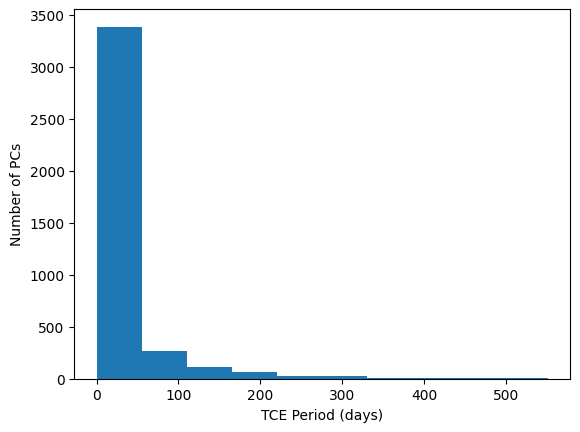

In [6]:
plt.hist(tab['tce_period'])
plt.xlabel('TCE Period (days)')
plt.ylabel('Number of PCs')

The vast majority of the TCE periods are fewer than 50 days. The planetary candidates that would most benefit from the long baseline afforded by combining the Kepler, K2, and TESS datasets are those with longer periods. Here, we'll again filter our table to just include those PCs with periods of greater than 6 months, or 180 days. 

In [7]:
# Only include those table rows with TCE period greater than 180 days
tab=tab[tab['tce_period']>180]
n=len(tab)
print('Number of Kepler TCEs marked PC and period > 180 days:',n)

Number of Kepler TCEs marked PC and period > 180 days: 123


## Find all TESS 20-second targets for these Kepler TCEs
The Kepler and K2 missions studied a limited portion of the sky, but TESS has studied (and continues to study) the full sky. This means that all Kepler and K2 identifications are likely to be included in the TESS Catalog. However, they may not all 

JRK what is the science reason for only 20-second targets? Why not also 2 min? Clearly 30 min not frequent enough.

### Finding observations in the MAST archive by the Kepler ID number
When we use astroquery.mast's Observations.query_object or query_object_count functions, the object's name will be resolved into sky coordinates (RA and Dec), so that all observations of that coordinate will be returned. This allows us to search by the Kepler ID column, even though TESS will not have used the Kepler ID to refer to the name of the target. Likewise, other ways to search the MAST archive, such as query_criteria, will also resolve the coordinates of the name input to 'objectname'. See the [astroquery documentation about MAST Queries](https://astroquery.readthedocs.io/en/latest/mast/mast.html) for more information. 

Unfortunately, this method of searching is time-intensive, which makes it very inconvenient when cross-matching hundreds or more targets from different missions. Let's illustrate this point with the first row in our filtered table. Notice that this call to MAST will take at least a few seconds; we can use the "time" magic command to tell us how long it takes.

In [8]:
# Query all observations in MAST that correspond to the coordinates of the first row's Kepler ID, within 1 arcsecond.
%time obs_table = Observations.query_object('KIC '+str(tab[0]['kepid']),radius=1*u.arcsec)

CPU times: user 56.4 ms, sys: 5.01 ms, total: 61.4 ms
Wall time: 7.73 s


In [9]:
# View the observation table
obs_table.pprint()

intentType obs_collection provenance_name ... srcDen   obsid   distance
---------- -------------- --------------- ... ------ --------- --------
   science           TESS            SPOC ...    nan  27463635      0.0
   science           TESS            SPOC ...    nan  62431369      0.0
   science           TESS            SPOC ...    nan  62870781      0.0
   science           TESS            SPOC ...    nan  92616912      0.0
   science           TESS            SPOC ...    nan  95133363      0.0
   science           TESS            SPOC ...    nan  62349937      0.0
   science           TESS            SPOC ...    nan  62793303      0.0
   science           TESS            SPOC ...    nan  91547081      0.0
   science           TESS            SPOC ...    nan  93772051      0.0
   science    SPITZER_SHA    SSC Pipeline ...    nan   1730213      0.0
       ...            ...             ... ...    ...       ...      ...
   science           HLSP             QLP ...    nan 129964724  

In [10]:
# View all unique entries in the 'target_name' column
np.unique(obs_table['target_name'])

137685450
2144.049
Kepler10-1-2-1-1-1-1-1
--
TESS FFI
TICA FFI
kplr002581316


From the above, we can see that inputting an 'objectname' of 'KIC 2581316' from the Kepler Input Catalog (KIC) identification number, we find all the observations of that target from all different missions - even if they did not specifically refer to the name of the target by it. 

### Get coordinates and TESS Input Catalog (TIC) numbers from Vizier
We will find that it is far faster to search MAST for TESS observations by TESS Input Catalog (TIC) number. To do that, we need to figure out the TICs that correspond to the KICs. To do this, we'll search the Tess Input Catalog, which is hosted in Vizier: [TESS Input Catalog version 8.2 (TIC v.8.2)(Paegert+,2021)](http://vizier.cds.unistra.fr/viz-bin/VizieR-3?-source=IV/39/tic82&-out.max=50&-out.form=HTML%20Table&-out.add=_r&-out.add=_RAJ,_DEJ&-sort=_r&-oc.form=sexa)

First, we'll setup astroquery to search Vizier in such a way that we do not limit the number of rows returned, and we specifically want to return the columns corresponding to coordinates (RA and Dec), TIC, and KIC. Next, we'll create new columns that match the data types we will find in Vizier.

In [12]:
Vizier.ROW_LIMIT = -1
v=Vizier(columns=['_RAJ2000','_DEJ2000','TIC','KIC'])

In [13]:
tab.add_columns([np.zeros(n),np.zeros(n),np.zeros(n,dtype=np.int32),np.zeros(n,dtype=np.int64)],
                names=['_RAJ2000','_DEJ2000','KIC','TIC'])

We will query Vizier for each row in our table of TCEs, and then save the resulting RA, Dec, KIC (just to confirm!) and TIC in our new columns. To guard against connectivity errors interrupting the workflow, we will put the Vizier query in a [try statement](https://docs.python.org/3/tutorial/errors.html#handling-exceptions).

In [16]:
# Query a subset of the TESS Input Catalog 
#result=Vizier.query_object('KIC 2581316',catalog=['IV/39/tic82']) # Length: 282
#for i,row in enumerate(tab):
for i,row in enumerate(tab):
    # Use a "try/except" because sometimes there is no response
    try:
        result=v.query_object('KIC '+str(row['kepid']),radius=1*u.arcsec,catalog=['IV/39/tic82'])
        # If there is more than one result, choose the one with matching KIC.
        if len(result[0])>1: result=result[0][result[0]['KIC']==row['kepid']]
        tab[i]['_RAJ2000','_DEJ2000','KIC','TIC']=result[0][0]['_RAJ2000','_DEJ2000','KIC','TIC']
    except:
        print('Error in',i)
        continue

Error in 58
Error in 75


We can now view the updated table and confirm that the KIC values from Vizier match the 'kepid' values from our original table, except in any rows where an error was found.

In [17]:
tab.pprint()
print(np.where(tab['kepid']!=tab['KIC']))

 kepid   tce_period tce_period_err ...    _DEJ2000      KIC       TIC   
-------- ---------- -------------- ... -------------- -------- ---------
 2581316    217.832    7.71254e-05 ... 37.86013507452  2581316 137685450
 2975770    369.079     0.00262336 ... 38.11458125146  2975770 121395761
 2576107    205.583    0.000156979 ... 37.88763673242  2576107 137220754
 3103227    225.583     0.00304541 ... 38.29470683575  3103227 121395435
 3326377     198.71    0.000624291 ... 38.40533619115  3326377 120962548
 3645438    386.372      0.0107079 ... 38.78773924713  3645438 137151626
 3634051    453.544     0.00352963 ... 38.74028625567  3634051 121457557
 3747817    184.772     0.00139617 ... 38.87490712824  3747817 137319097
 4918309    186.436     0.00047676 ... 40.02181730105  4918309 122301308
 4760478    287.378      0.0024477 ... 39.88652749598  4760478 184011870
     ...        ...            ... ...            ...      ...       ...
11026582    240.572     0.00146005 ... 48.558688961

### Finding the number of TESS lightcurves by TIC
To examine each of the 123 long-period planetary candidates that also have TESS lightcurves, it is more efficient to just query MAST for the counts (total numbers) of observations that match our criteria. 
JRK is this true - time it. 

In [29]:
i=0
row=tab[i]
print(row['kepid'])

2581316


In [20]:
%%time
obs_table = Observations.query_criteria(objectname='KIC '+str(row['kepid']),radius=1*u.arcsec,
                                        project='TESS',obs_collection='HLSP',dataproduct_type='timeseries') # If do obs_collection= TESS, get 35. QLP, 0. SPOC, 0. HLSP tons.
print(obs_table)

intentType obs_collection provenance_name ...   objID     objID1  distance
---------- -------------- --------------- ... --------- --------- --------
   science           HLSP             QLP ... 238704431 238704431      0.0
   science           HLSP       TESS-SPOC ... 236201504 236201504      0.0
   science           HLSP             QLP ... 233072513 233072513      0.0
   science           HLSP       TESS-SPOC ...  86990707  86990707      0.0
   science           HLSP       TESS-SPOC ... 236589725 236589725      0.0
   science           HLSP             QLP ... 176855027 176855027      0.0
   science           HLSP           TASOC ... 180937380 180937380      0.0
   science           HLSP           CDIPS ... 153404312 153404312      0.0
   science           HLSP             QLP ... 178725662 178725662      0.0
   science           HLSP       TESS-SPOC ... 174135111 174135111      0.0
   science           HLSP             QLP ...  87488608  87488608      0.0
   science           HLSP

In [23]:
%%time
count = Observations.query_criteria_count(objectname='KIC '+str(row['kepid']),radius=1*u.arcsec,
                                        project='TESS',obs_collection='HLSP',dataproduct_type='timeseries')
print(count)

12
CPU times: user 24.5 ms, sys: 5.11 ms, total: 29.6 ms
Wall time: 149 ms


In [33]:
%%time
obs_table2=Observations.query_criteria(target_name=row['TIC'],
                                      project='TESS',obs_collection='HLSP',dataproduct_type='timeseries')
print(obs_table2['t_exptime'])
print(obs_table2.columns)

t_exptime
---------
   1800.0
   1800.0
   1800.0
    600.0
    600.0
    600.0
    600.0
   1800.0
    600.0
    600.0
    600.0
    600.0
<TableColumns names=('intentType','obs_collection','provenance_name','instrument_name','project','filters','wavelength_region','target_name','target_classification','obs_id','s_ra','s_dec','dataproduct_type','proposal_pi','calib_level','t_min','t_max','t_exptime','em_min','em_max','obs_title','t_obs_release','proposal_id','proposal_type','sequence_number','s_region','jpegURL','dataURL','dataRights','mtFlag','srcDen','obsid','objID')>
CPU times: user 17.4 ms, sys: 0 ns, total: 17.4 ms
Wall time: 48 ms


In [31]:
%%time
count2=Observations.query_criteria_count(target_name=row['TIC'],
                                      project='TESS',obs_collection='HLSP',dataproduct_type='timeseries')
print(count2)

12
CPU times: user 6.95 ms, sys: 327 µs, total: 7.27 ms
Wall time: 78.8 ms


In [ ]:
tab.add_column(np.empty(n,dtype=int),name='TESS HLSP')

In [ ]:
for i,row in enumerate(tab):
    obs_table = Observations.query_criteria_count(target_name='TIC '+str(row['TIC']),
                                        project='TESS',obs_collection='HLSP',
                                       t_exptime=[20.0,120.0])
    if len(obs_table)>0: tab['TESS fast'][i]=True
    print(i,tab['TESS fast'][i])
np.sum(tab['TESS fast'])

In [ ]:
tab[tab['TESS fast']==True]['kepid','tce_period','tce_period_err','tce_num_transits']

# Examine the combined light curves for one target

In [ ]:
search_result=lk.search_lightcurve(1164109) # Works if it's input as an integer.
#search_result=lk.search_lightcurve('KIC '+str(1164109)) # Only returns Kepler light kurves.
# 291.65265, 36.89502
#search_result=lk.search_lightcurve('291.65265, 36.89502')
search_result

In [ ]:
search_result=lk.search_lightcurve(8056665,exptime='short')
search_result

In [ ]:
# Load 'em all. Where does it "go"?
lc_collection = search_result.download_all()

In [ ]:
# Could be interesting to visualize just Kepler, then just TESS, then combined.
lc_stitched = lc_collection.stitch()
lc_stitched.plot()

Where possible (if the code supports it), use code examples that visually display the data in the tutorial. For example, if you are showing an object such as a Table, display a preview of the table:

## Exercises
Exercises are optional, but encouraged. Exercises can be woven into the main content of your tutorial, or appear in their own section toward the end of the tutorial. Final exercises can be more challenging, similar to homework problems. They can be minimal or take as long as 30 minutes to an hour to complete. If you do have one or more exercises in your tutorial, be sure to leave a blank code cell underneath each to show the reader that they're meant to try out their new skill right there. You may also want to include a "solutions" notebook next to your main notebook for the reader to check their work after they have finished their attempt.

## Additional Resources

This section is optional. Try to weave resource links into the main content of your tutorial so that they are falling in line with the context of your writing. For resources that do not fit cleanly into your narrative, you may include an additional resources section at the end of your tutorial. Usually a list of links using Markdown bullet list plus link format is appropriate:

- [MAST API](https://mast.stsci.edu/api/v0/index.html)
- [Kepler Archive Page (MAST)](https://archive.stsci.edu/kepler/)
- [Kepler Archive Manual](https://archive.stsci.edu/kepler/manuals/archive_manual.pdf)
- [Exo.MAST website](https://exo.mast.stsci.edu/)

## Citations
Provide your reader with guidelines on how to cite open source software and other resources in their own published work.

```
If you use `astropy` or `lightkurve` for published research, please cite the
authors. Follow these links for more information about citing `astropy` and
`lightkurve`:

* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `lightkurve`](http://docs.lightkurve.org/about/citing.html)

```

## About this Notebook
Let the world know who the author of this great tutorial is! If possible and appropriate, include a contact email address for users who might need support (for example, `archive@stsci.edu`). You can also optionally include keywords, your funding source, or a last update date in this section.

**Author(s):** Jessie Blogs, Jenny V. Medina, Thomas Dutkiewicz <br>
**Keyword(s):** Tutorial, lightkurve, kepler, introduction, template <br>
**Last Updated:** Aug 2022 <br>
**Next Review:** Mar 2023
***
[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 